In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
import os
from module import Model_Training
import logging
tf.get_logger().setLevel(logging.ERROR)


2023-02-28 11:43:55.246419: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-28 11:43:56.447776: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/include:/usr/local/cuda/lib64:/usr/local/cuda-11.2/lib64::/usr/local/cuda/extras/CUPTI/lib64:/home/jj/miniconda3/envs/tf/lib/
2023-02-28 11:43:56.447886: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LI

In [2]:
# full_img_path = '/mnt/d/Datasets/INbreast/full/'
roi_img_path = '/mnt/d/Datasets/INbreast/ROI/'
img_height = 300
img_width = 300
batch_size = 16
os.environ['TF_ENABLE_GPU_GARBAGE_COLLECTION'] = 'false'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  roi_img_path+'train/',
  label_mode="categorical",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)
  
val_ds = tf.keras.utils.image_dataset_from_directory(
  roi_img_path+'val/',
  label_mode="categorical",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 329 files belonging to 2 classes.
Found 80 files belonging to 2 classes.


In [4]:
AUTOTUNE = tf.data.AUTOTUNE
train = train_ds.prefetch(AUTOTUNE)

val = val_ds.prefetch(AUTOTUNE)

In [5]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  roi_img_path+'test/',
  label_mode="categorical",
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 71 files belonging to 2 classes.


In [6]:
class PrintLR(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = tf.keras.backend.get_value(self.model.optimizer.lr)
        print(
            f' Epoch {epoch}: accuracy={logs["categorical_accuracy"]:.4f}, loss={logs["loss"]:.4f}, '+
            f'val_accuracy={logs["val_categorical_accuracy"]:.4f}, val_loss={logs["val_loss"]:.4f}, '+
            f' - lr={lr:.7f}')

# Inception V3

In [7]:
model, inception_dense_history = Model_Training.main(    
    'inceptionv3',
    train,
    val,
    epochs=20,
    patience=4,
    Earlystop=False,
    augmentation = True,
    trainable_layers = False,
    regulariser=False,
    train_log='/home/jj/FYP/log/InceptionV3_INbreast_2/InceptionV3_INbreast_2_dense.csv',
    load_weights = False,
    save_weights = '/home/jj/FYP/Checkpoint/InceptionV3_INbreast_2/Dense/best_model',
    learning_rate=1e-4,
    optimiser=tf.keras.optimizers.Adam(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Recall(class_id=0),tf.keras.metrics.Recall(class_id=1)],
    callbacks = [PrintLR()],
    img_height=300,img_width=300)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 300, 300, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 300, 300, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 131072)            0     

2023-02-26 23:13:45.058135: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-02-26 23:13:47.255558: W tensorflow/tsl/framework/bfc_allocator.cc:360] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.
2023-02-26 23:13:47.956718: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-02-26 23:13:47.977639: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f658800dee0 initialized for platform CUDA (this does not guarantee

21/21 [==============================] - 15s 250ms/step - loss: 0.9064 - categorical_accuracy: 0.5775 - recall: 0.6258 - recall_1: 0.5345 - val_loss: 0.5346 - val_categorical_accuracy: 0.8125 - val_recall: 0.6750 - val_recall_1: 0.9500
Epoch 2/2
21/21 [==============================] - 4s 204ms/step - loss: 0.7859 - categorical_accuracy: 0.6474 - recall: 0.3806 - recall_1: 0.8851 - val_loss: 0.5005 - val_categorical_accuracy: 0.7625 - val_recall: 0.5750 - val_recall_1: 0.9500
Epoch 3/3
21/21 [==============================] - 4s 200ms/step - loss: 0.4820 - categorical_accuracy: 0.7690 - recall: 0.6194 - recall_1: 0.9023 - val_loss: 0.3582 - val_categorical_accuracy: 0.8625 - val_recall: 0.8000 - val_recall_1: 0.9250
Epoch 4/4
21/21 [==============================] - 4s 189ms/step - loss: 0.5326 - categorical_accuracy: 0.7964 - recall: 0.7484 - recall_1: 0.8391 - val_loss: 0.3553 - val_categorical_accuracy: 0.8500 - val_recall: 0.8000 - val_recall_1: 0.9000
Epoch 5/5
21/21 [============

## Fine Tune

In [8]:
model, inception_fine_tune_history = Model_Training.main(    
    'inceptionv3',
    train,
    val,
    epochs=300,
    patience=5,
    Earlystop=10,
    augmentation = True,
    trainable_layers = 63,
    regulariser=tf.keras.regularizers.L2(l2=0.1),
    train_log='/home/jj/FYP/log/InceptionV3_INbreast_2/InceptionV3_INbreast_2_Fine_Tune.csv',
    load_weights = '/home/jj/FYP/Checkpoint/InceptionV3_INbreast_2/Dense/best_model',
    save_weights = '/home/jj/FYP/Checkpoint/InceptionV3_INbreast_2/Fine_Tune/best_model',
    learning_rate=1e-3,
    optimiser=tf.keras.optimizers.legacy.SGD(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
    callbacks = [PrintLR()],
    img_height=300,img_width=300)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 300, 300, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 300, 300, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 300, 300, 3)      0         
 bda)                                                            
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 flatten_1 (Flatten)         (None, 131072)            0   

## Figures

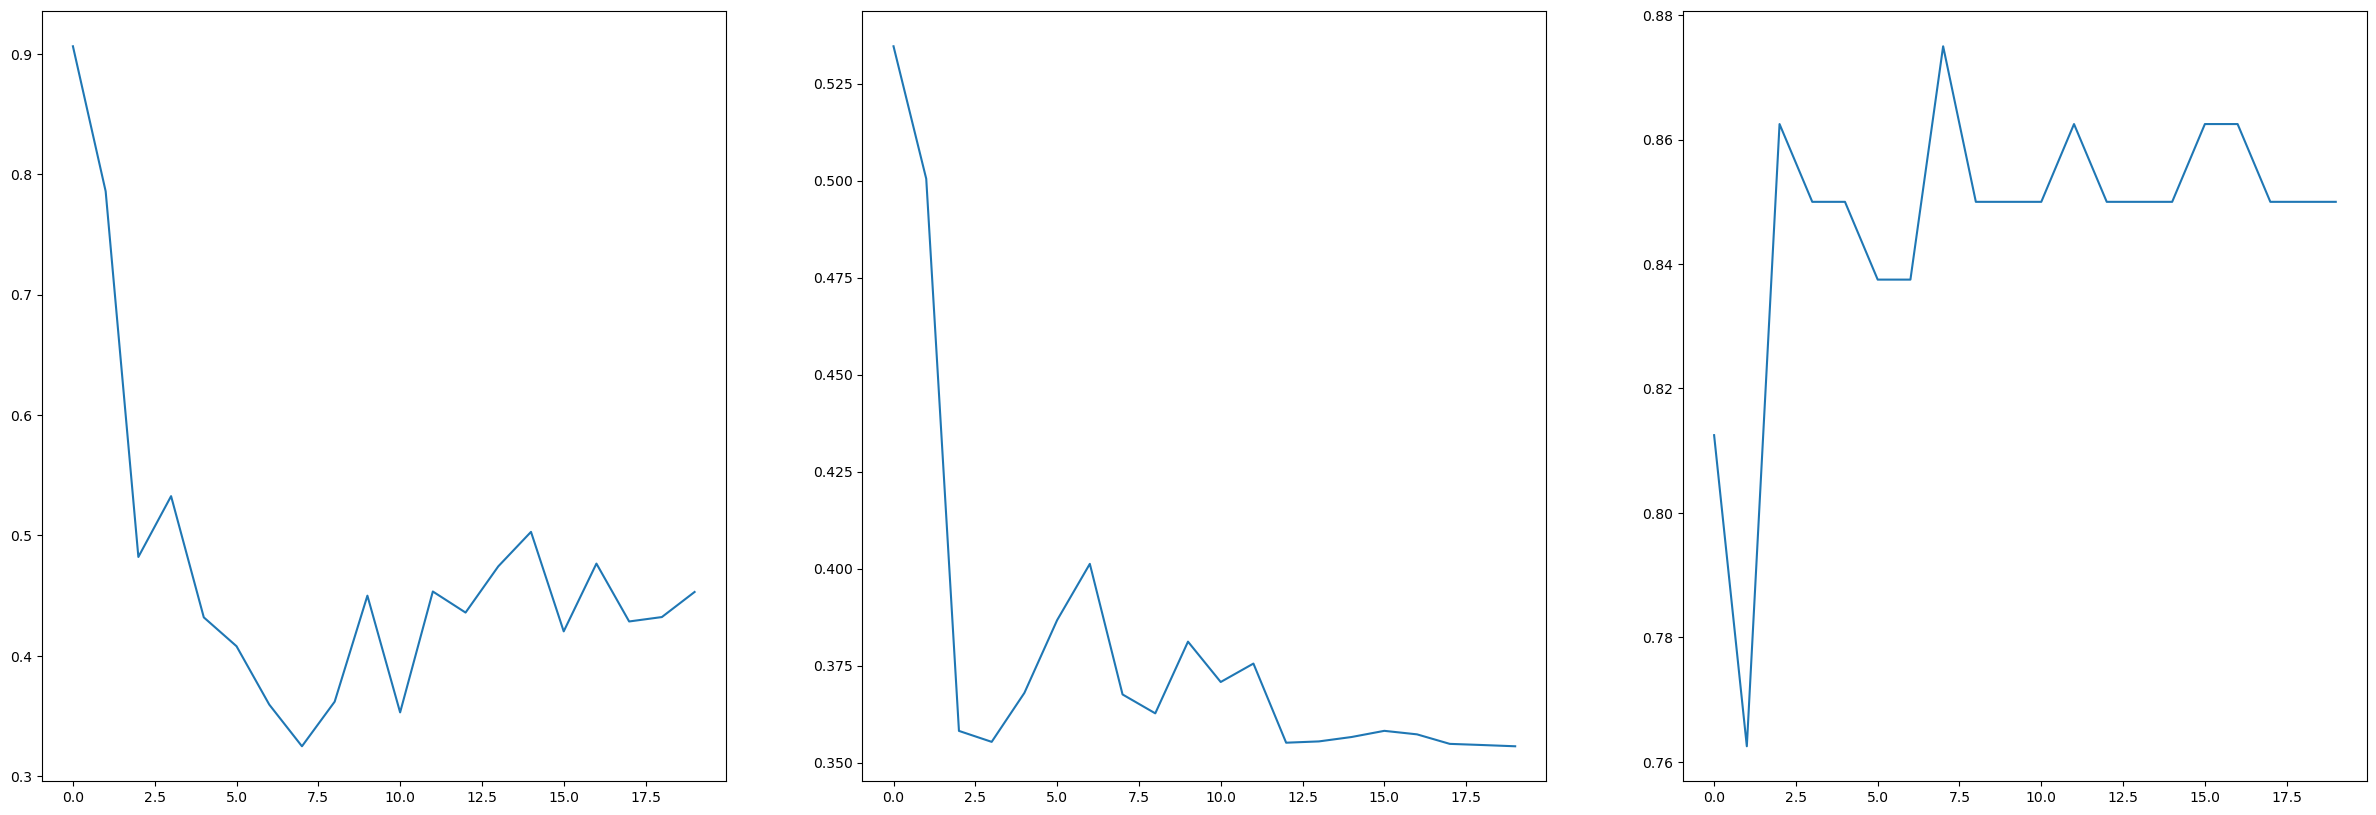

In [9]:
plt.figure(figsize=(30,10))
plt.subplot(131)
plt.plot(inception_dense_history['train_loss'])
plt.subplot(132)
plt.plot(inception_dense_history['val_loss'])
plt.subplot(133)
plt.plot(inception_dense_history['val_acc'])

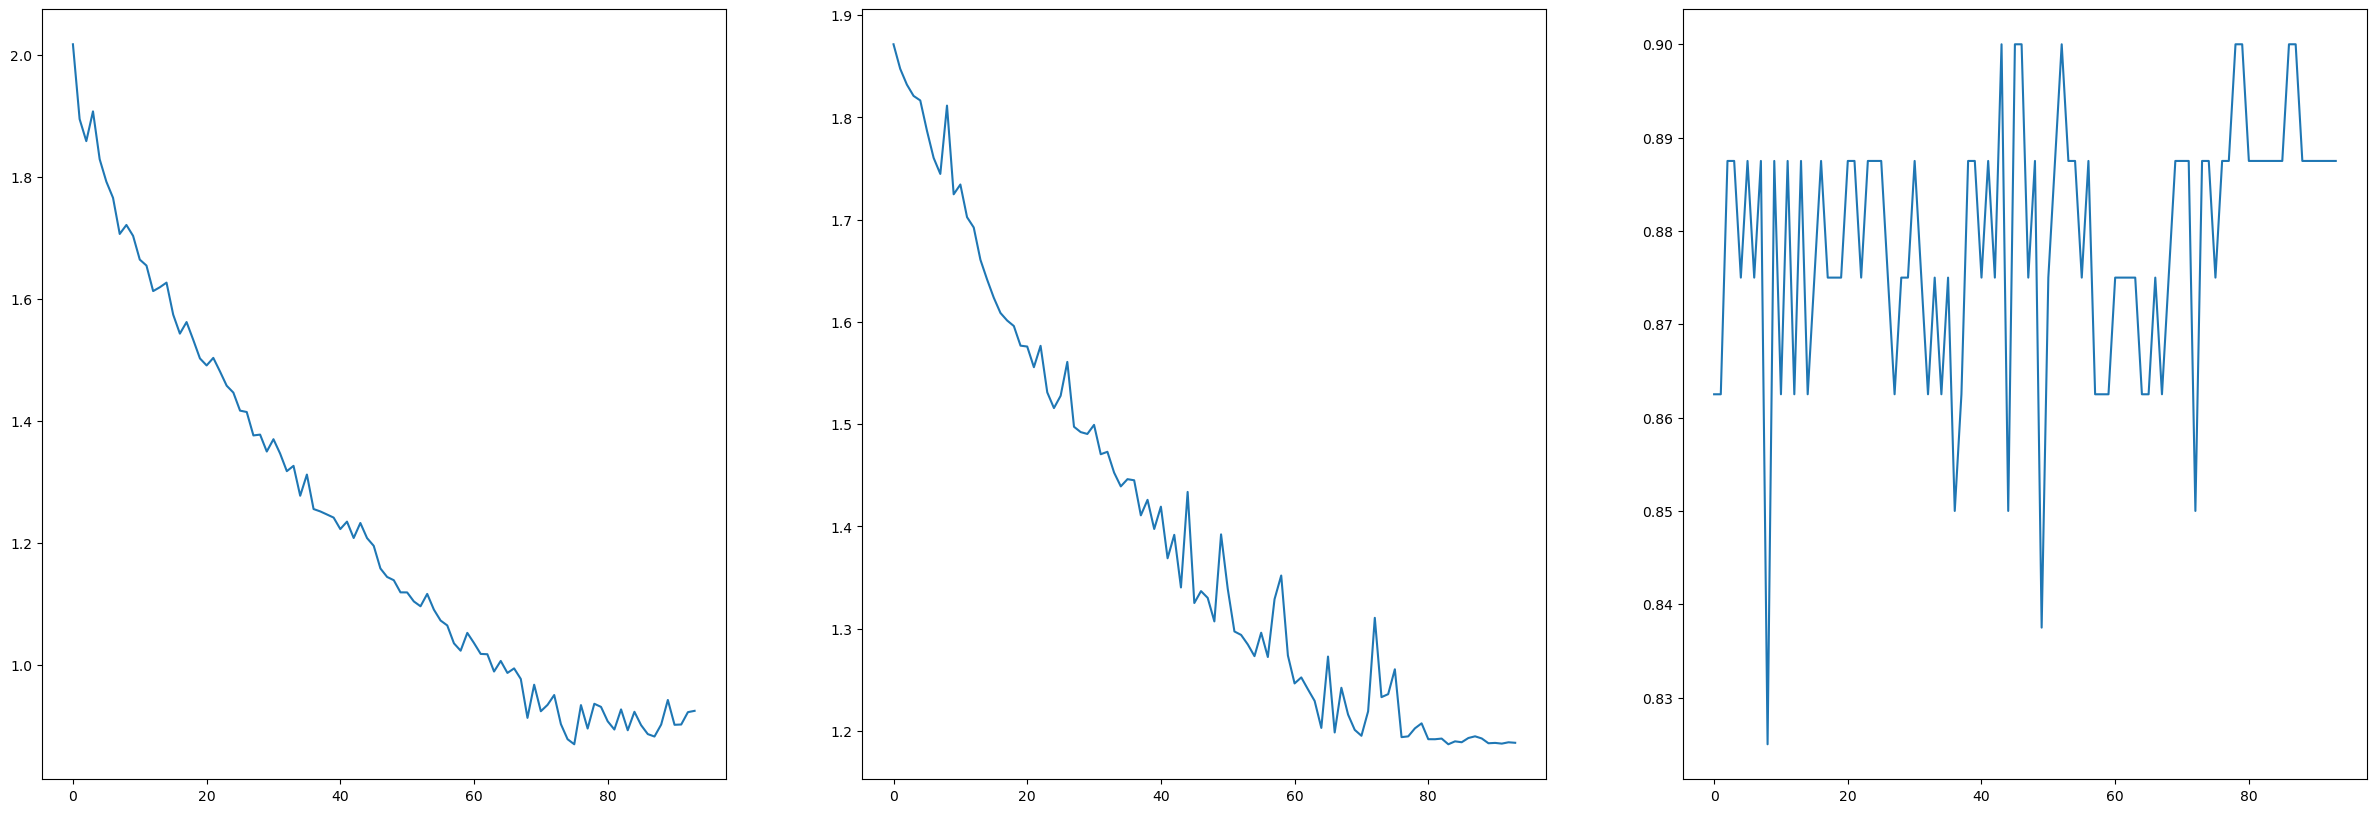

In [10]:
plt.figure(figsize=(30,10))
plt.subplot(131)
plt.plot(inception_fine_tune_history['train_loss'])
plt.subplot(132)
plt.plot(inception_fine_tune_history['val_loss'])
plt.subplot(133)
plt.plot(inception_fine_tune_history['val_acc'])


## Test

In [11]:
model.load_weights('/home/jj/FYP/Checkpoint/InceptionV3_INbreast_2/Fine_Tune/best_model')
model.evaluate(test_ds)
tf.keras.backend.clear_session()

5/5 [==============================] - 3s 189ms/step - loss: 1.1362 - categorical_accuracy: 0.8611 - precision_8: 0.8571 - precision_9: 0.8750


In [12]:
Model_Training.store_misclassified(model,test_ds,
'/mnt/d/Datasets/INbreast/ROI/InceptionV3_misclassified/')

5/5 [==============================] - 1s 32ms/step


# Inceptionv3

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  roi_img_path+'normalise/train/',
  label_mode="categorical",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)
val_ds = tf.keras.utils.image_dataset_from_directory(
  roi_img_path+'normalise/val/',
  label_mode="categorical",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)
test_ds = tf.keras.utils.image_dataset_from_directory(
  roi_img_path+'normalise/test/',
  label_mode="categorical",
  shuffle=False,
  image_size=(img_height, img_width),
  batch_size=batch_size)
AUTOTUNE = tf.data.AUTOTUNE
train = train_ds.prefetch(AUTOTUNE)
val = val_ds.prefetch(AUTOTUNE)

Found 320 files belonging to 2 classes.
Found 80 files belonging to 2 classes.
Found 72 files belonging to 2 classes.


## Initialising

In [25]:
model, inception_dense_history = Model_Training.main(    
    'inceptionv3',
    train,
    val,
    epochs=20,
    patience=4,
    Earlystop=False,
    augmentation = True,
    trainable_layers = False,
    flatten='flatten',
    regulariser=False,
    train_log='/home/jj/FYP/log/InceptionV3_INbreast_normalise_3/dense.csv',
    load_weights = False,
    save_weights = '/home/jj/FYP/Checkpoint/InceptionV3_INbreast_normalise_3/Dense/best_model',
    learning_rate=1e-4,
    optimiser=tf.keras.optimizers.Adam(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Recall(class_id=0),tf.keras.metrics.Recall(class_id=1)],
    callbacks = [PrintLR()],
    img_height=300,img_width=300)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 300, 300, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 300, 300, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 131072)            0     

## Fine Tuning


In [26]:
model, inception_fine_tune_history = Model_Training.main(    
    'inceptionv3',
    train,
    val,
    epochs=300,
    patience=5,
    Earlystop=10,
    augmentation = True,
    flatten='flatten',
    trainable_layers = 63,
    regulariser=tf.keras.regularizers.L2(l2=0.1),
    train_log='/home/jj/FYP/log/InceptionV3_INbreast_normalise_3/Fine_Tune.csv',
    load_weights = '/home/jj/FYP/Checkpoint/InceptionV3_INbreast_normalise_3/Dense/best_model',
    save_weights = '/home/jj/FYP/Checkpoint/InceptionV3_INbreast_normalise_3/Fine_Tune/best_model',
    learning_rate=1e-3,
    optimiser=tf.keras.optimizers.legacy.SGD(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
    callbacks = [PrintLR()],
    img_height=300,img_width=300)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 300, 300, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 300, 300, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 300, 300, 3)      0         
 bda)                                                            
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 flatten_1 (Flatten)         (None, 131072)            0   

## Test

In [9]:
metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Recall(),tf.keras.metrics.Precision(),tf.keras.metrics.AUC()]
model = Model_Training.build_model('inceptionv3',trainable_layers=False,metrics=metrics,load_weights='/home/jj/FYP/Checkpoint/InceptionV3_INbreast_normalise_2/Fine_Tune/best_model')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 300, 300, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 300, 300, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 131072)            0     

In [6]:
model.evaluate(test_ds)

2023-02-27 23:32:33.414899: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-02-27 23:32:35.777732: W tensorflow/tsl/framework/bfc_allocator.cc:360] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


1/5 [=====>........................] - ETA: 21s - loss: 0.1399 - categorical_accuracy: 0.9375 - recall_8: 0.9375 - precision: 0.9375 - auc: 0.9961

2023-02-27 23:32:36.476987: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


5/5 [==============================] - 7s 417ms/step - loss: 0.1852 - categorical_accuracy: 0.9306 - recall_8: 0.9306 - precision: 0.9306 - auc: 0.9786


[0.18519790470600128,
 0.9305555820465088,
 0.9305555820465088,
 0.9305555820465088,
 0.9785879254341125]

In [10]:
model.load_weights('/home/jj/FYP/Checkpoint/InceptionV3_INbreast_normalise_2/Fine_Tune/best_model')
model.evaluate(test_ds)

2023-02-28 12:12:26.575719: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-02-28 12:12:29.241368: W tensorflow/tsl/framework/bfc_allocator.cc:360] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


3/5 [=================>............] - ETA: 0s - loss: 0.1169 - categorical_accuracy: 0.9583 - recall_8: 0.9583 - precision: 0.9583 - auc: 0.9922 

2023-02-28 12:12:29.961873: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


5/5 [==============================] - 8s 356ms/step - loss: 0.1852 - categorical_accuracy: 0.9306 - recall_8: 0.9306 - precision: 0.9306 - auc: 0.9786


[0.18517307937145233,
 0.9305555820465088,
 0.9305555820465088,
 0.9305555820465088,
 0.9785879254341125]

In [80]:
misclassified = Model_Training.store_misclassified(model,test_ds,
'/mnt/d/Datasets/INbreast/ROI/normalise/InceptionV3_normalise_2_misclassified/')
tf.keras.backend.clear_session()

5/5 [==============================] - 1s 33ms/step


: 

In [79]:
misclassified

['/mnt/d/Datasets/INbreast/ROI/normalise/test/benign/22670832_1.png',
 '/mnt/d/Datasets/INbreast/ROI/normalise/test/benign/53587014_1.png',
 '/mnt/d/Datasets/INbreast/ROI/normalise/test/malignant/24055445_1.png',
 '/mnt/d/Datasets/INbreast/ROI/normalise/test/malignant/24055483_1.png',
 '/mnt/d/Datasets/INbreast/ROI/normalise/test/malignant/50994895_1.png']

In [65]:
prediction = model.predict(test_ds)

5/5 [==============================] - 0s 85ms/step


In [10]:
import numpy as np
labels=['benign','malignant']
test_predicted_labels = np.argmax(prediction, axis=1)
test_predicted_labels = [labels[i] for i in test_predicted_labels]
# incorrect sequence
# test_true_labels = np.concatenate([y for x, y in test_ds], axis=0)
misclassified_indices = []
for i,y in enumerate(test_true_labels):
    if y[1] == 1:
        if test_predicted_labels[i] != labels[1]:
            misclassified_indices.append(i)
    elif y[0] == 1:
        if test_predicted_labels[i] != labels[0]:
            misclassified_indices.append(i)
test_filenames = test_ds.file_paths
misclassified_images = [test_filenames[i] for i in misclassified_indices]

In [48]:
test = test_ds.unbatch()

In [74]:
truths=[]
for _,y in test_ds:
    truths.append(y.numpy())
truths

[array([[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]], dtype=float32),
 array([[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]], dtype=float32),
 array([[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]], dtype=float32),
 array([[1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 

# prediction

In [16]:
model.evaluate(test_ds)

5/5 [==============================] - 0s 42ms/step - loss: 0.1852 - categorical_accuracy: 0.9306 - recall_8: 0.9306 - precision: 0.9306 - auc: 0.9786


[0.18517307937145233,
 0.9305555820465088,
 0.9305555820465088,
 0.9305555820465088,
 0.9785879254341125]

In [15]:
prediction = model.predict(test_ds)
prediction
i=0
test = test_ds.unbatch()
for x,y in test:
    predict = prediction[i]
    print(str(predict) + ', '+ str(y))
    i+=1

5/5 [==============================] - 1s 108ms/step
[9.9998379e-01 1.6234333e-05], tf.Tensor([1. 0.], shape=(2,), dtype=float32)
[0.99746513 0.0025349 ], tf.Tensor([1. 0.], shape=(2,), dtype=float32)
[1.0000000e+00 3.9598897e-09], tf.Tensor([1. 0.], shape=(2,), dtype=float32)
[0.8796384  0.12036159], tf.Tensor([1. 0.], shape=(2,), dtype=float32)
[0.97896177 0.02103828], tf.Tensor([1. 0.], shape=(2,), dtype=float32)
[0.72285646 0.2771436 ], tf.Tensor([1. 0.], shape=(2,), dtype=float32)
[0.84792703 0.15207301], tf.Tensor([1. 0.], shape=(2,), dtype=float32)
[0.8624244  0.13757564], tf.Tensor([1. 0.], shape=(2,), dtype=float32)
[0.992863   0.00713701], tf.Tensor([1. 0.], shape=(2,), dtype=float32)
[0.99493426 0.00506573], tf.Tensor([1. 0.], shape=(2,), dtype=float32)
[0.30195096 0.69804907], tf.Tensor([1. 0.], shape=(2,), dtype=float32)
[9.9940145e-01 5.9858832e-04], tf.Tensor([1. 0.], shape=(2,), dtype=float32)
[9.9999976e-01 2.1936489e-07], tf.Tensor([1. 0.], shape=(2,), dtype=float32)


In [31]:
for x,y in test:
    print(y)

tf.Tensor([1. 0.], shape=(2,), dtype=float32)
tf.Tensor([1. 0.], shape=(2,), dtype=float32)
tf.Tensor([1. 0.], shape=(2,), dtype=float32)
tf.Tensor([0. 1.], shape=(2,), dtype=float32)
tf.Tensor([1. 0.], shape=(2,), dtype=float32)
tf.Tensor([1. 0.], shape=(2,), dtype=float32)
tf.Tensor([0. 1.], shape=(2,), dtype=float32)
tf.Tensor([1. 0.], shape=(2,), dtype=float32)
tf.Tensor([1. 0.], shape=(2,), dtype=float32)
tf.Tensor([1. 0.], shape=(2,), dtype=float32)
tf.Tensor([0. 1.], shape=(2,), dtype=float32)
tf.Tensor([1. 0.], shape=(2,), dtype=float32)
tf.Tensor([1. 0.], shape=(2,), dtype=float32)
tf.Tensor([1. 0.], shape=(2,), dtype=float32)
tf.Tensor([0. 1.], shape=(2,), dtype=float32)
tf.Tensor([1. 0.], shape=(2,), dtype=float32)
tf.Tensor([1. 0.], shape=(2,), dtype=float32)
tf.Tensor([0. 1.], shape=(2,), dtype=float32)
tf.Tensor([1. 0.], shape=(2,), dtype=float32)
tf.Tensor([1. 0.], shape=(2,), dtype=float32)
tf.Tensor([1. 0.], shape=(2,), dtype=float32)
tf.Tensor([1. 0.], shape=(2,), dty

In [11]:
for i,y in enumerate(test_true_labels):
    if y[1] == 1:
        if test_predicted_labels[i] != labels[0]:
            print(str(i)+' not malignant')
    elif y[0] == 1:
        if test_predicted_labels[i] != labels[1]:
            print(str(i)+' not benign')

1 not benign
3 not benign
5 not benign
6 not benign
7 not benign
8 not benign
9 not benign
10 not benign
13 not benign
14 not benign
17 not benign
19 not benign
21 not benign
23 not benign
25 not benign
26 not benign
27 not benign
28 not benign
29 not benign
30 not benign
31 not benign
32 not benign
34 not benign
35 not benign
36 not benign
37 not benign
38 not benign
39 not benign
41 not benign
42 not benign
43 not benign
44 not benign
45 not benign
46 not benign
47 not benign
49 not benign
51 not benign
52 not benign
53 not benign
57 not benign
59 not benign
61 not benign
62 not benign
64 not benign
66 not benign
67 not benign
69 not benign
70 not benign
71 not benign


In [22]:
for i,x in enumerate(test_predicted_labels):
    # print(x)
    # print(np.argmax(prediction[i]))
    print(str(x)+', Truth: '+str(np.argmax(test_true_labels[i])))

benign, Truth: 0
benign, Truth: 1
benign, Truth: 0
benign, Truth: 0
benign, Truth: 0
benign, Truth: 0
benign, Truth: 1
benign, Truth: 0
malignant, Truth: 0
benign, Truth: 0
benign, Truth: 0
benign, Truth: 0
benign, Truth: 0
benign, Truth: 0
benign, Truth: 0
malignant, Truth: 0
benign, Truth: 0
benign, Truth: 1
benign, Truth: 1
malignant, Truth: 0
benign, Truth: 1
malignant, Truth: 0
benign, Truth: 1
benign, Truth: 1
benign, Truth: 1
malignant, Truth: 0
benign, Truth: 0
benign, Truth: 0
benign, Truth: 0
benign, Truth: 1
malignant, Truth: 0
malignant, Truth: 0
malignant, Truth: 0
benign, Truth: 1
benign, Truth: 1
malignant, Truth: 0
benign, Truth: 0
benign, Truth: 1
malignant, Truth: 0
benign, Truth: 0
benign, Truth: 0
malignant, Truth: 0
benign, Truth: 0
benign, Truth: 0
benign, Truth: 0
benign, Truth: 0
benign, Truth: 1
benign, Truth: 0
malignant, Truth: 1
malignant, Truth: 0
malignant, Truth: 0
malignant, Truth: 1
benign, Truth: 1
malignant, Truth: 1
benign, Truth: 0
benign, Truth: 0


In [43]:
for i,y in enumerate(test_true_labels):
    if y[1] == 1:
        if test_predicted_labels[i] != labels[1]:
            misclassified_indices.append(i)
    elif y[0] == 1:
        if test_predicted_labels[i] != labels[0]:
            misclassified_indices.append(i)

35

# EfficientNet V2M

## Initialising

In [7]:
weights = '/home/jj/FYP/Checkpoint/Efficientnetv2m_INbreast_CLAHE/'
train_log = '/home/jj/FYP/log/Efficientnetv2m_INbreast_CLAHE/'
model, effnetv2m_dense_history = Model_Training.main(    
    'efficientnetv2m',
    train,
    val,
    epochs=20,
    patience=4,
    Earlystop=False,
    augmentation = True,
    trainable_layers = False,
    regulariser=False,
    train_log= train_log+'dense.csv',
    load_weights = False,
    save_weights = weights+'Dense/best_model',
    learning_rate=1e-4,
    optimiser=tf.keras.optimizers.Adam(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
    callbacks = [PrintLR()],
    img_height=300,img_width=300)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 efficientnetv2-m (Functiona  (None, 10, 10, 1280)     53150388  
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 128000)            0         
                                                                 
 dense (Dense)               (None, 8)                 1024008   
                                                                 
 dense_1 (Dense)             (None, 8)                 72        
                                                             

2023-02-18 12:28:18.575506: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-02-18 12:28:21.336309: W tensorflow/tsl/framework/bfc_allocator.cc:360] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.
2023-02-18 12:28:21.621556: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-02-18 12:28:21.640299: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x1c8cb820 initialized for platform CUDA (this does not guarantee tha

20/20 [==============================] - 23s 388ms/step - loss: 0.6504 - categorical_accuracy: 0.5875 - precision_2: 0.5447 - precision_3: 0.7260 - val_loss: 0.5499 - val_categorical_accuracy: 0.7875 - val_precision_2: 0.7556 - val_precision_3: 0.8286
Epoch 2/2
20/20 [==============================] - 5s 260ms/step - loss: 0.5537 - categorical_accuracy: 0.7844 - precision_2: 0.8071 - precision_3: 0.7667 - val_loss: 0.5047 - val_categorical_accuracy: 0.8125 - val_precision_2: 0.7778 - val_precision_3: 0.8571
Epoch 3/3
20/20 [==============================] - 5s 262ms/step - loss: 0.5158 - categorical_accuracy: 0.8281 - precision_2: 0.8333 - precision_3: 0.8235 - val_loss: 0.4632 - val_categorical_accuracy: 0.8125 - val_precision_2: 0.7660 - val_precision_3: 0.8788
Epoch 4/4
20/20 [==============================] - 6s 266ms/step - loss: 0.4990 - categorical_accuracy: 0.8500 - precision_2: 0.8794 - precision_3: 0.8268 - val_loss: 0.4682 - val_categorical_accuracy: 0.8500 - val_precision_2

## Fine Tuning

In [8]:
model, effnetv2m_fine_tune_history = Model_Training.main(    
    'efficientnetv2m',
    train,
    val,
    epochs=300,
    patience=10,
    Earlystop=50,
    augmentation = True,
    trainable_layers = 75,
    regulariser=tf.keras.regularizers.l2(0.1),
    train_log= train_log+'Fine_Tune.csv',
    load_weights = weights+'Dense/best_model',
    save_weights = weights+'Fine_Tune/best_model',
    learning_rate=1e-3,
    optimiser=tf.keras.optimizers.legacy.SGD(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
    callbacks = [PrintLR()],
    img_height=300,img_width=300)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 300, 300, 3)       0         
                                                                 
 efficientnetv2-m (Functiona  (None, 10, 10, 1280)     53150388  
 l)                                                              
                                                                 
 flatten_1 (Flatten)         (None, 128000)            0         
                                                                 
 dense_4 (Dense)             (None, 8)                 1024008   
                                                                 
 dense_5 (Dense)             (None, 8)                 72        
                                                           

2023-02-18 12:30:42.606535: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.41GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-02-18 12:30:42.606599: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.41GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-02-18 12:30:42.618250: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.39GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-02-18 12:30:42.618283: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU

20/20 [==============================] - 20s 422ms/step - loss: 1.1725 - categorical_accuracy: 0.8281 - precision_4: 0.8571 - precision_5: 0.8056 - val_loss: 1.1017 - val_categorical_accuracy: 0.8625 - val_precision_4: 0.8372 - val_precision_5: 0.8919
Epoch 2/2
20/20 [==============================] - 6s 292ms/step - loss: 1.1638 - categorical_accuracy: 0.8375 - precision_4: 0.8759 - precision_5: 0.8087 - val_loss: 1.0987 - val_categorical_accuracy: 0.8625 - val_precision_4: 0.8372 - val_precision_5: 0.8919
Epoch 3/3
20/20 [==============================] - 6s 291ms/step - loss: 1.1486 - categorical_accuracy: 0.8375 - precision_4: 0.8705 - precision_5: 0.8122 - val_loss: 1.0904 - val_categorical_accuracy: 0.8625 - val_precision_4: 0.8372 - val_precision_5: 0.8919
Epoch 4/4
20/20 [==============================] - 6s 292ms/step - loss: 1.1521 - categorical_accuracy: 0.8281 - precision_4: 0.8676 - precision_5: 0.7989 - val_loss: 1.1003 - val_categorical_accuracy: 0.8625 - val_precision_4

## Figures

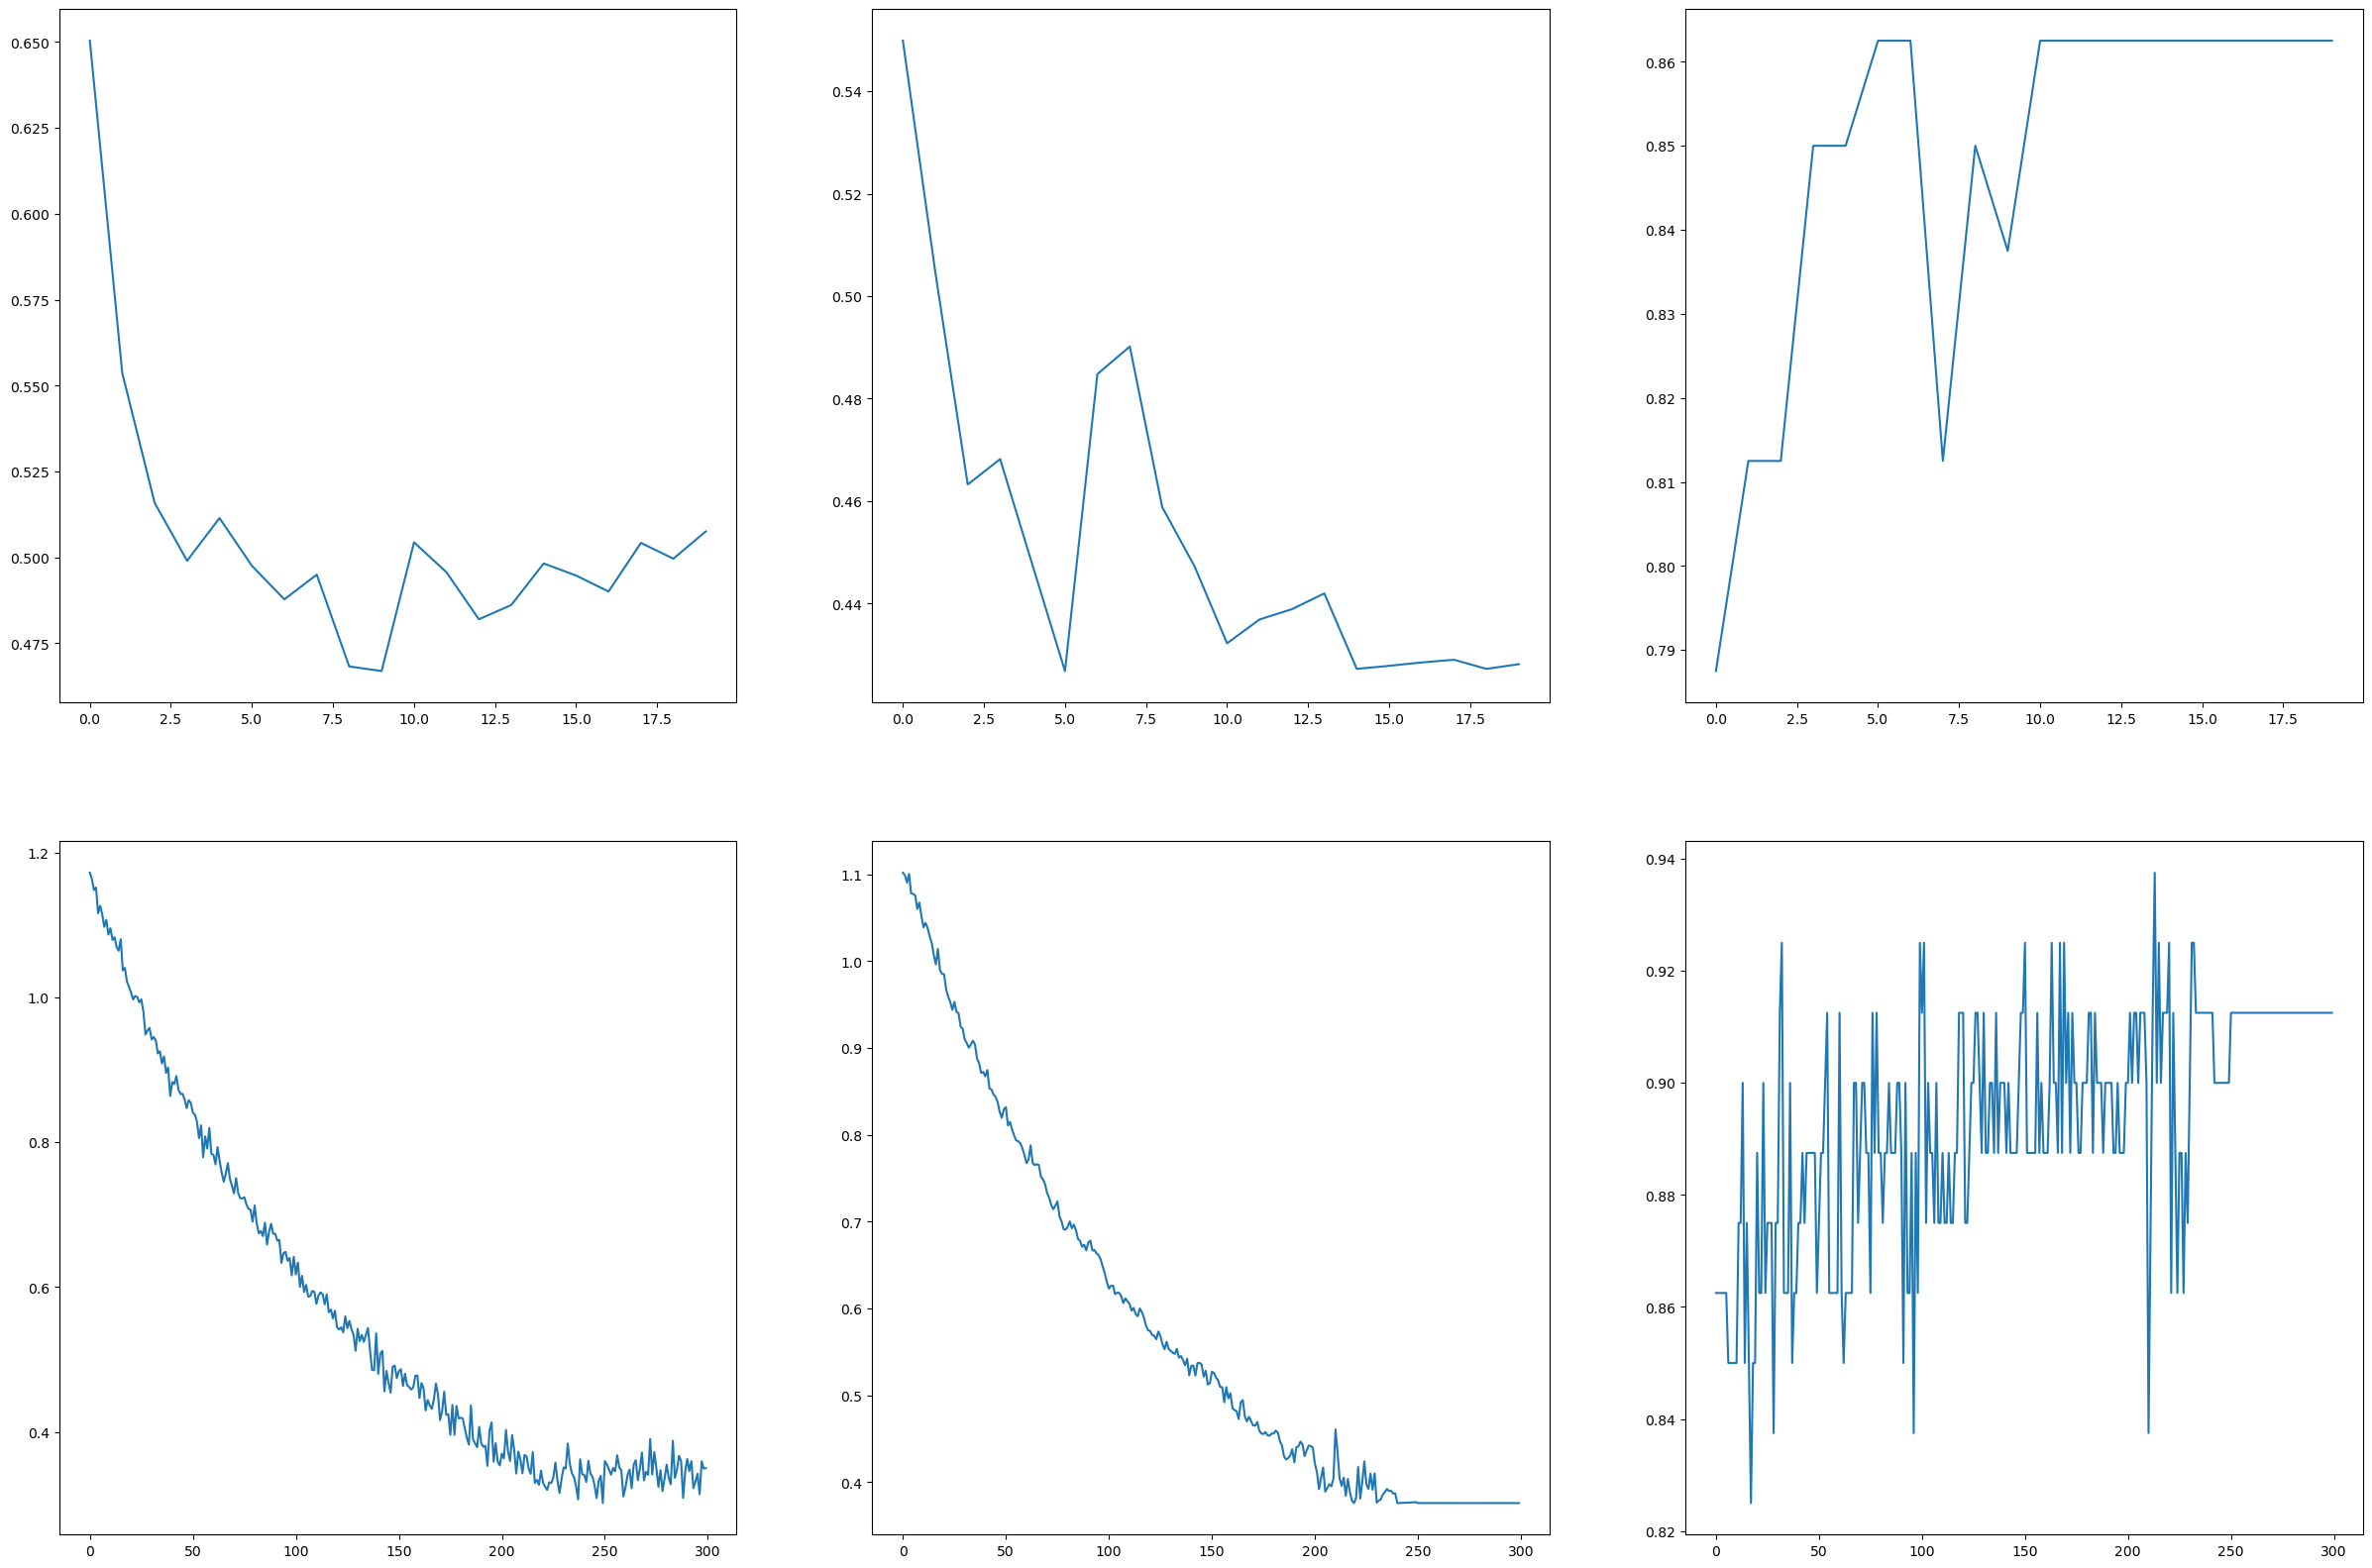

In [9]:
plt.figure(figsize=(30,20))
plt.subplot(231)
plt.plot(effnetv2m_dense_history['train_loss'])
plt.subplot(232)
plt.plot(effnetv2m_dense_history['val_loss'])
plt.subplot(233)
plt.plot(effnetv2m_dense_history['val_acc'])
plt.subplot(234)
plt.plot(effnetv2m_fine_tune_history['train_loss'])
plt.subplot(235)
plt.plot(effnetv2m_fine_tune_history['val_loss'])
plt.subplot(236)
plt.plot(effnetv2m_fine_tune_history['val_acc'])

## Test

In [10]:
model.load_weights(weights+'Fine_Tune/best_model')
model.evaluate(test)
tf.keras.backend.clear_session()

5/5 [==============================] - 1s 235ms/step - loss: 0.5218 - categorical_accuracy: 0.8194 - precision_4: 0.9302 - precision_5: 0.6552


# Resnet50

## Initialising

In [11]:
weights = '/home/jj/FYP/Checkpoint/Resnet50_INbreast_CLAHE/'
train_log = '/home/jj/FYP/log/Resnet50_INbreast_CLAHE/'
model, resnet_dense_history = Model_Training.main(    
    'resnet50',
    train,
    val,
    epochs=20,
    patience=4,
    Earlystop=False,
    augmentation = True,
    trainable_layers = False,
    regulariser=False,
    train_log= train_log+'dense.csv',
    load_weights = False,
    save_weights = weights+'Dense/best_model',
    learning_rate=1e-4,
    optimiser=tf.keras.optimizers.Adam(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
    callbacks = [PrintLR()],
    img_height=300,img_width=300)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 300, 300, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 300, 300, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 10, 10, 2048)      23587712  
                                                                 
 flatten (Flatten)           (None, 204800)            0         
                                                             

## Fine Tune

In [12]:
model, resnet_fine_tune_history = Model_Training.main(    
    'resnet50',
    train,
    val,
    epochs=300,
    patience=10,
    Earlystop=50,
    augmentation = True,
    trainable_layers = 22,
    regulariser=tf.keras.regularizers.l2(0.1),
    train_log= train_log+'Fine_Tune.csv',
    load_weights = weights+'Dense/best_model',
    save_weights = weights+'Fine_Tune/best_model',
    learning_rate=1e-3,
    optimiser=tf.keras.optimizers.legacy.SGD(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
    callbacks = [PrintLR()],
    img_height=300,img_width=300)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 300, 300, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 300, 300, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 300, 300, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 10, 10, 2048)      23587712  
                                                                 
 flatten_1 (Flatten)         (None, 204800)            0   

## Figures

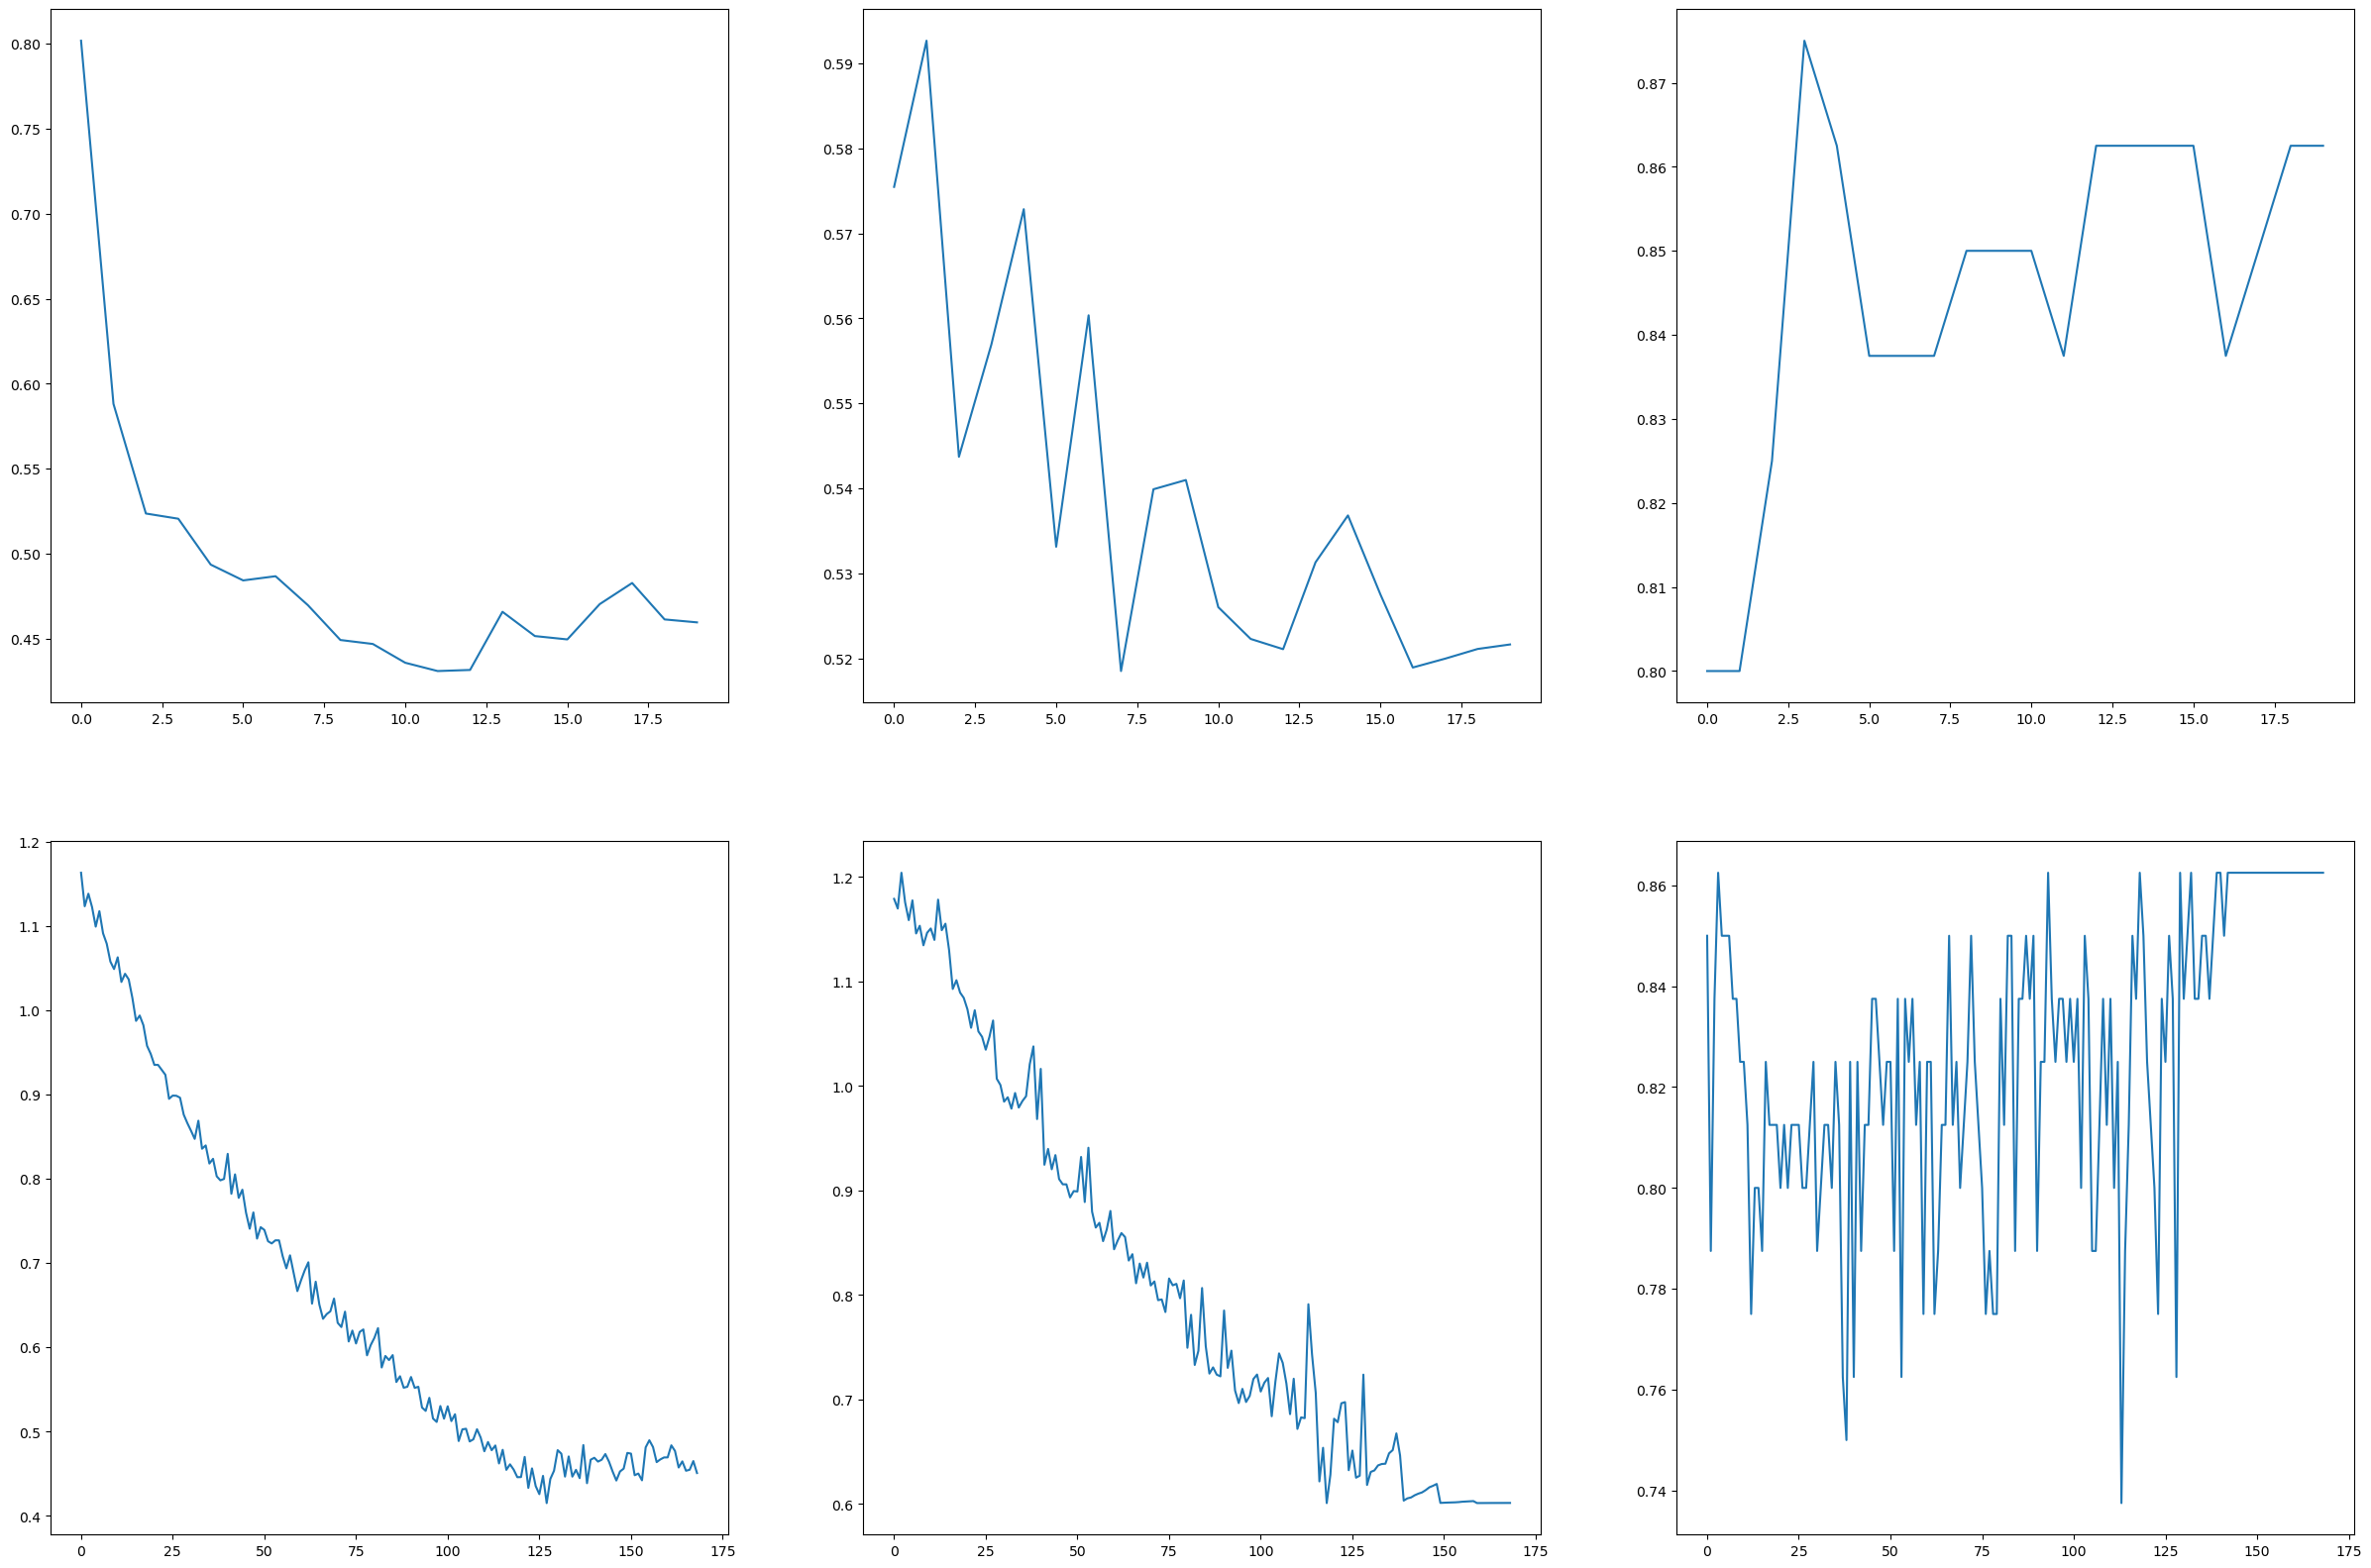

In [13]:
plt.figure(figsize=(30,20))
plt.subplot(231)
plt.plot(resnet_dense_history['train_loss'])
plt.subplot(232)
plt.plot(resnet_dense_history['val_loss'])
plt.subplot(233)
plt.plot(resnet_dense_history['val_acc'])
plt.subplot(234)
plt.plot(resnet_fine_tune_history['train_loss'])
plt.subplot(235)
plt.plot(resnet_fine_tune_history['val_loss'])
plt.subplot(236)
plt.plot(resnet_fine_tune_history['val_acc'])

## Test

In [14]:
model.load_weights(weights+'Fine_Tune/best_model')
model.evaluate(test)
tf.keras.backend.clear_session()

5/5 [==============================] - 1s 140ms/step - loss: 0.6923 - categorical_accuracy: 0.8611 - precision_2: 0.8704 - precision_3: 0.8333


# VGG16

In [15]:
weights = '/home/jj/FYP/Checkpoint/Vgg16_INbreast_CLAHE/'
train_log = '/home/jj/FYP/log/Vgg16_INbreast_CLAHE/'
model, vgg16_dense_history = Model_Training.main(    
    'vgg16',
    train,
    val,
    epochs=20,
    patience=4,
    Earlystop=False,
    augmentation = True,
    trainable_layers = False,
    regulariser=False,
    train_log= train_log+'dense.csv',
    load_weights = False,
    save_weights = weights+'Dense/best_model',
    learning_rate=1e-4,
    optimiser=tf.keras.optimizers.Adam(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
    callbacks = [PrintLR()],
    img_height=300,img_width=300)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 300, 300, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 300, 300, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 9, 9, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 41472)             0         
                                                             

2023-02-18 13:16:43.116416: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.11GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-02-18 13:16:43.116467: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.11GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


20/20 [==============================] - 10s 190ms/step - loss: 0.9105 - categorical_accuracy: 0.5125 - precision: 0.4961 - precision_1: 0.5233 - val_loss: 0.6799 - val_categorical_accuracy: 0.4625 - val_precision: 0.4795 - val_precision_1: 0.2857
Epoch 2/2
20/20 [==============================] - 4s 184ms/step - loss: 0.6366 - categorical_accuracy: 0.6500 - precision: 0.6319 - precision_1: 0.6688 - val_loss: 0.6009 - val_categorical_accuracy: 0.5125 - val_precision: 0.5070 - val_precision_1: 0.5556
Epoch 3/3
20/20 [==============================] - 4s 183ms/step - loss: 0.5516 - categorical_accuracy: 0.6875 - precision: 0.6440 - precision_1: 0.7519 - val_loss: 0.5511 - val_categorical_accuracy: 0.6375 - val_precision: 0.6000 - val_precision_1: 0.7200
Epoch 4/4
20/20 [==============================] - 4s 183ms/step - loss: 0.5816 - categorical_accuracy: 0.6344 - precision: 0.6159 - precision_1: 0.6538 - val_loss: 0.5313 - val_categorical_accuracy: 0.6125 - val_precision: 0.5763 - val_p

## Fine Tune

In [16]:
model, vgg16_fine_tune_history = Model_Training.main(    
    'vgg16',
    train,
    val,
    epochs=300,
    patience=10,
    Earlystop=50,
    augmentation = True,
    trainable_layers = 16,
    regulariser=tf.keras.regularizers.l2(0.1),
    train_log= train_log+'Fine_Tune.csv',
    load_weights = weights+'Dense/best_model',
    save_weights = weights+'Fine_Tune/best_model',
    learning_rate=1e-3,
    optimiser=tf.keras.optimizers.legacy.SGD(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
    callbacks = [PrintLR()],
    img_height=300,img_width=300)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 300, 300, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 300, 300, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 300, 300, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 9, 9, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 41472)             0   

2023-02-18 13:18:08.699114: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.18GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-02-18 13:18:08.699171: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.18GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


20/20 [==============================] - 9s 258ms/step - loss: 1.3452 - categorical_accuracy: 0.7437 - precision_2: 0.7017 - precision_3: 0.7986 - val_loss: 1.2051 - val_categorical_accuracy: 0.8625 - val_precision_2: 0.9143 - val_precision_3: 0.8222
Epoch 2/2
20/20 [==============================] - 5s 245ms/step - loss: 1.3422 - categorical_accuracy: 0.7156 - precision_2: 0.6860 - precision_3: 0.7500 - val_loss: 1.2572 - val_categorical_accuracy: 0.8125 - val_precision_2: 0.7551 - val_precision_3: 0.9032
Epoch 3/3
20/20 [==============================] - 5s 246ms/step - loss: 1.4892 - categorical_accuracy: 0.7937 - precision_2: 0.7543 - precision_3: 0.8414 - val_loss: 1.3550 - val_categorical_accuracy: 0.5000 - val_precision_2: 0.5000 - val_precision_3: 0.0000e+00
Epoch 4/4
20/20 [==============================] - 5s 245ms/step - loss: 1.3170 - categorical_accuracy: 0.7281 - precision_2: 0.6771 - precision_3: 0.8047 - val_loss: 1.2805 - val_categorical_accuracy: 0.8500 - val_precisio

## Figures

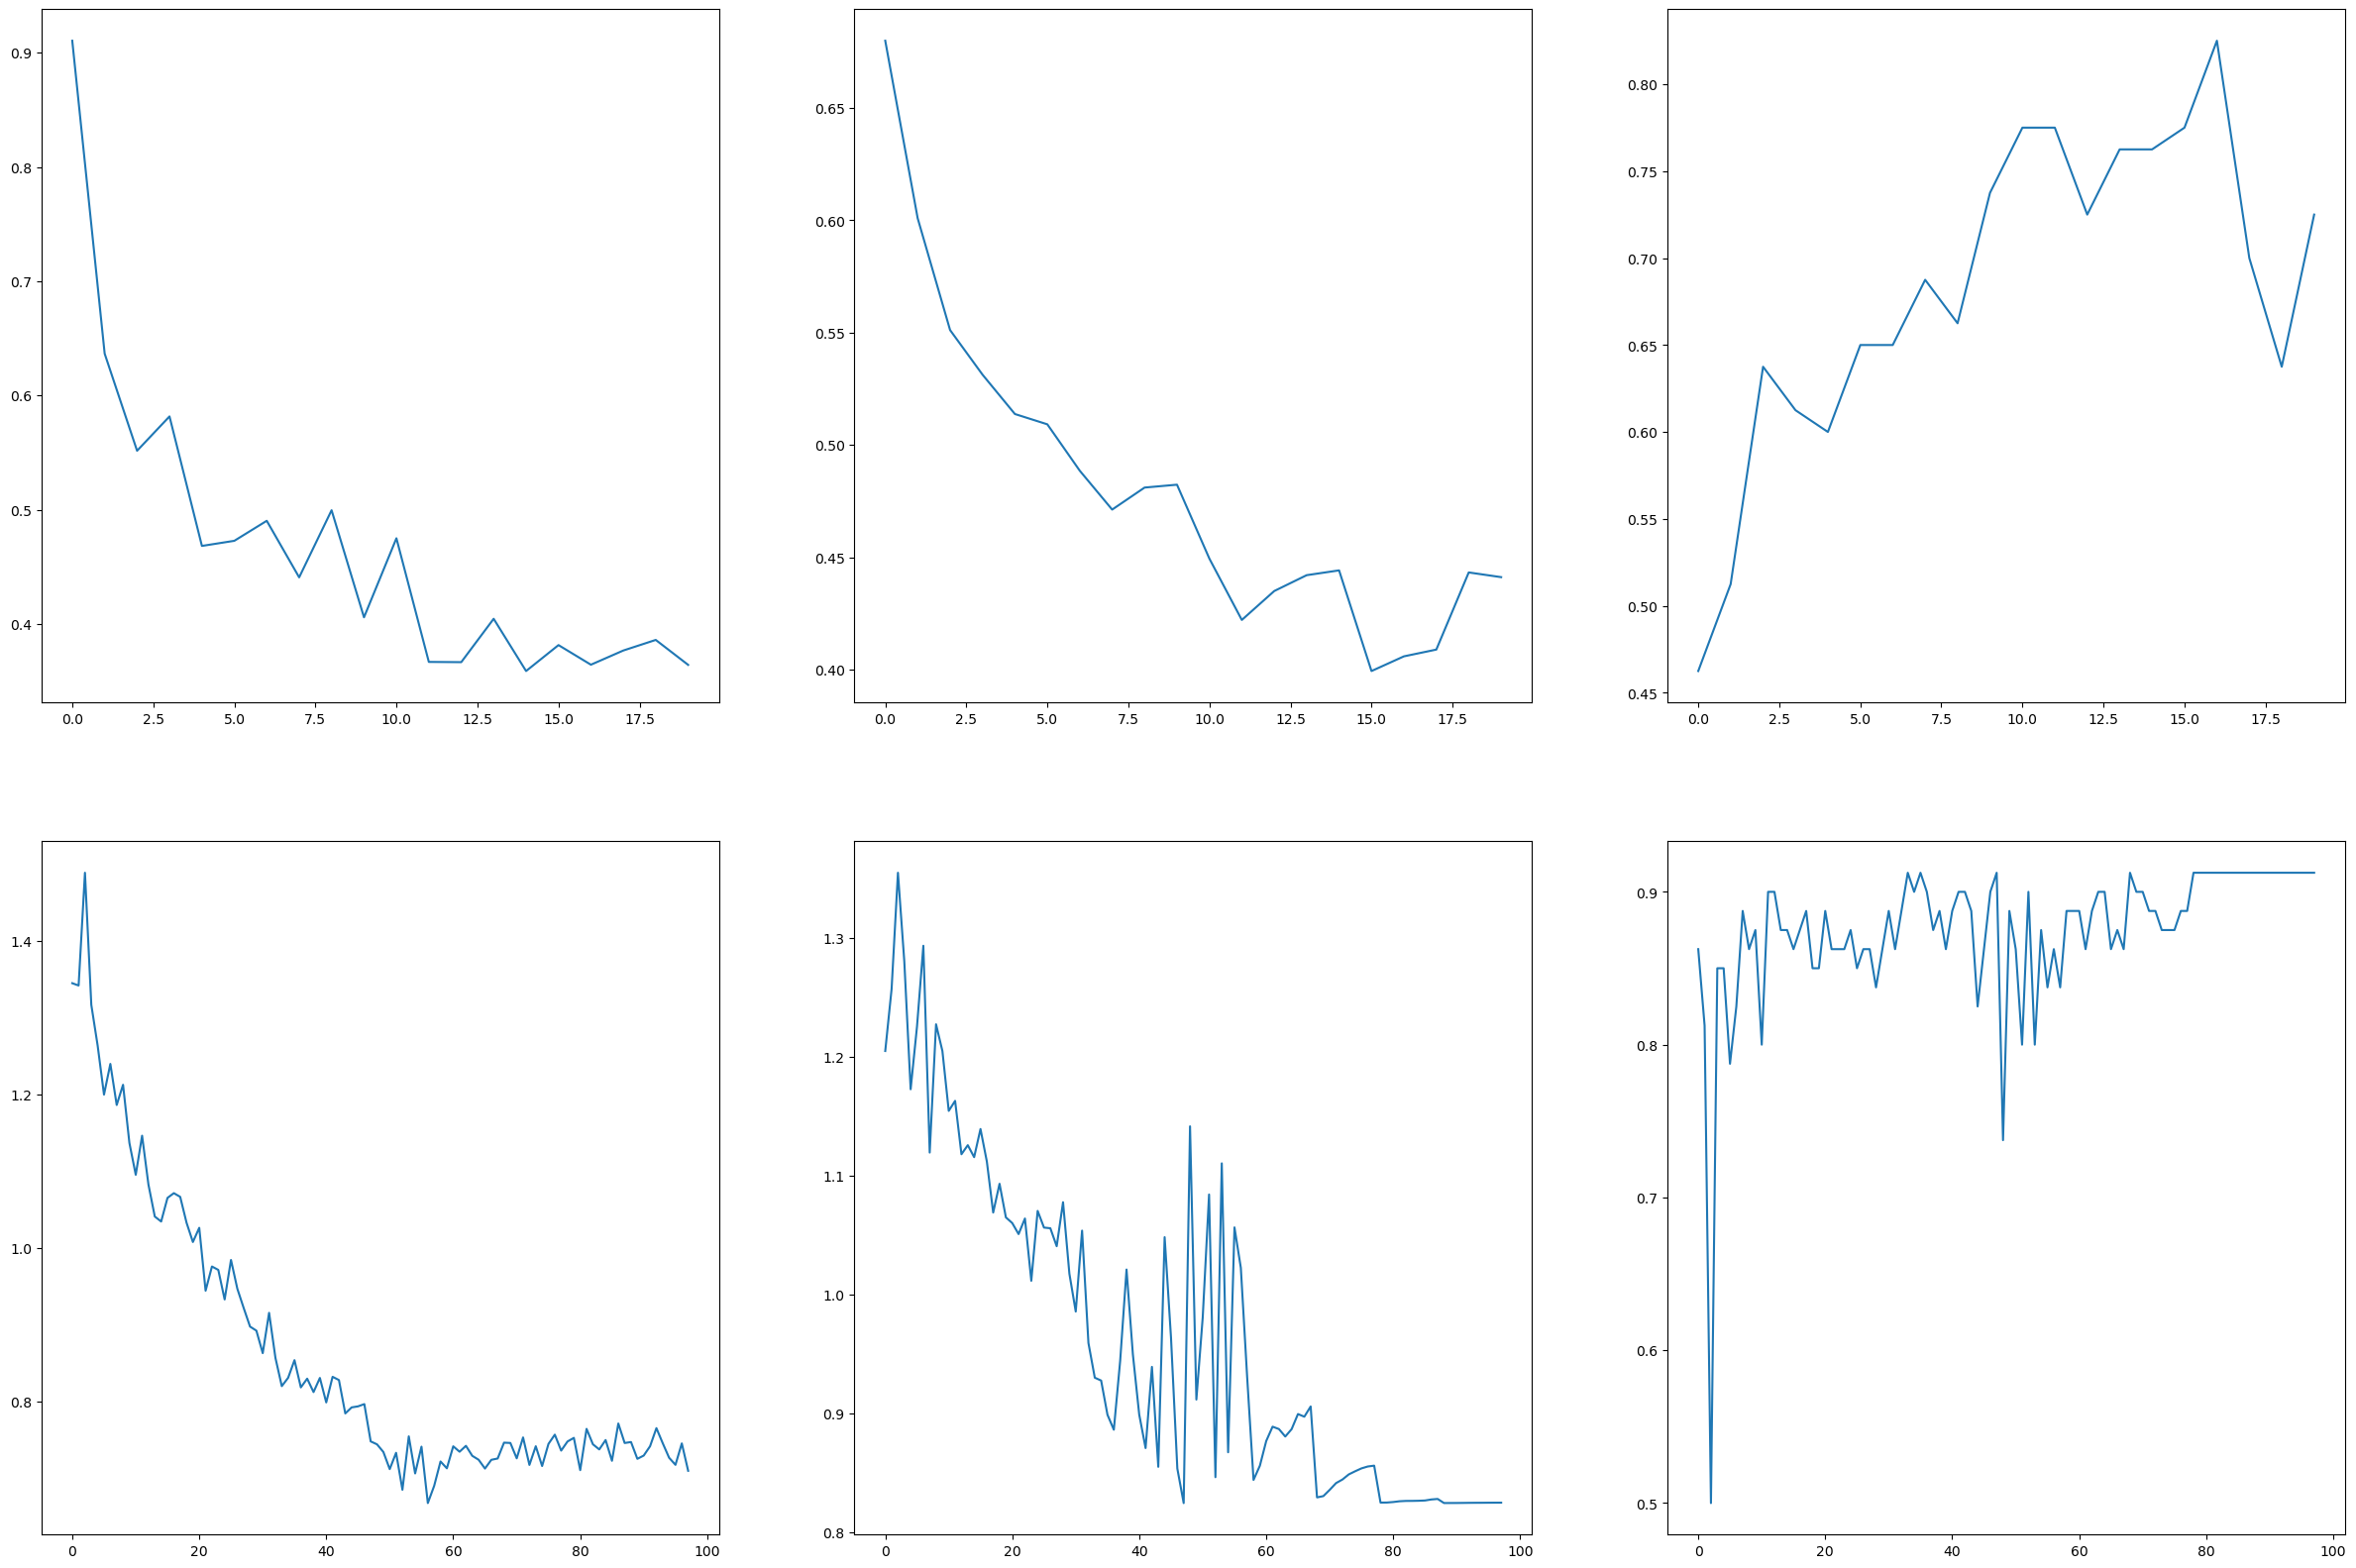

In [17]:
plt.figure(figsize=(30,20))
plt.subplot(231)
plt.plot(vgg16_dense_history['train_loss'])
plt.subplot(232)
plt.plot(vgg16_dense_history['val_loss'])
plt.subplot(233)
plt.plot(vgg16_dense_history['val_acc'])
plt.subplot(234)
plt.plot(vgg16_fine_tune_history['train_loss'])
plt.subplot(235)
plt.plot(vgg16_fine_tune_history['val_loss'])
plt.subplot(236)
plt.plot(vgg16_fine_tune_history['val_acc'])

## Test

In [18]:
model.load_weights(weights+'Fine_Tune/best_model')
model.evaluate(test)
tf.keras.backend.clear_session()

5/5 [==============================] - 2s 385ms/step - loss: 0.8391 - categorical_accuracy: 0.8611 - precision_2: 0.8846 - precision_3: 0.8000


# EfficientNet

In [19]:
weights = '/home/jj/FYP/Checkpoint/EffcientNetB3_INbreast_CLAHE/'
train_log = '/home/jj/FYP/log/EffcientNetB3_INbreast_CLAHE/'
model, effnet_dense_history = Model_Training.main(    
    'efficientnetb3',
    train,
    val,
    epochs=20,
    patience=4,
    Earlystop=False,
    augmentation = True,
    trainable_layers = False,
    regulariser=False,
    train_log= train_log+'dense.csv',
    load_weights = False,
    save_weights = weights+'Dense/best_model',
    learning_rate=1e-4,
    optimiser=tf.keras.optimizers.Adam(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
    callbacks = [PrintLR()],
    img_height=300,img_width=300)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 efficientnetb3 (Functional)  (None, 10, 10, 1536)     10783535  
                                                                 
 flatten (Flatten)           (None, 153600)            0         
                                                                 
 dense (Dense)               (None, 8)                 1228808   
                                                                 
 dense_1 (Dense)             (None, 8)                 72        
                                                                 
 dropout (Dropout)           (None, 8)                 0     

## Fine Tune

In [20]:
model, effnet_fine_tune_history = Model_Training.main(    
    'efficientnetb3',
    train,
    val,
    epochs=300,
    patience=10,
    Earlystop=50,
    augmentation = True,
    trainable_layers = 75,
    regulariser=tf.keras.regularizers.l2(0.1),
    train_log= train_log+'Fine_Tune.csv',
    load_weights = weights+'Dense/best_model',
    save_weights = weights+'Fine_Tune/best_model',
    learning_rate=1e-3,
    optimiser=tf.keras.optimizers.legacy.SGD(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
    callbacks = [PrintLR()],
    img_height=300,img_width=300)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 300, 300, 3)       0         
                                                                 
 efficientnetb3 (Functional)  (None, 10, 10, 1536)     10783535  
                                                                 
 flatten_1 (Flatten)         (None, 153600)            0         
                                                                 
 dense_4 (Dense)             (None, 8)                 1228808   
                                                                 
 dense_5 (Dense)             (None, 8)                 72        
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0   

## Figures

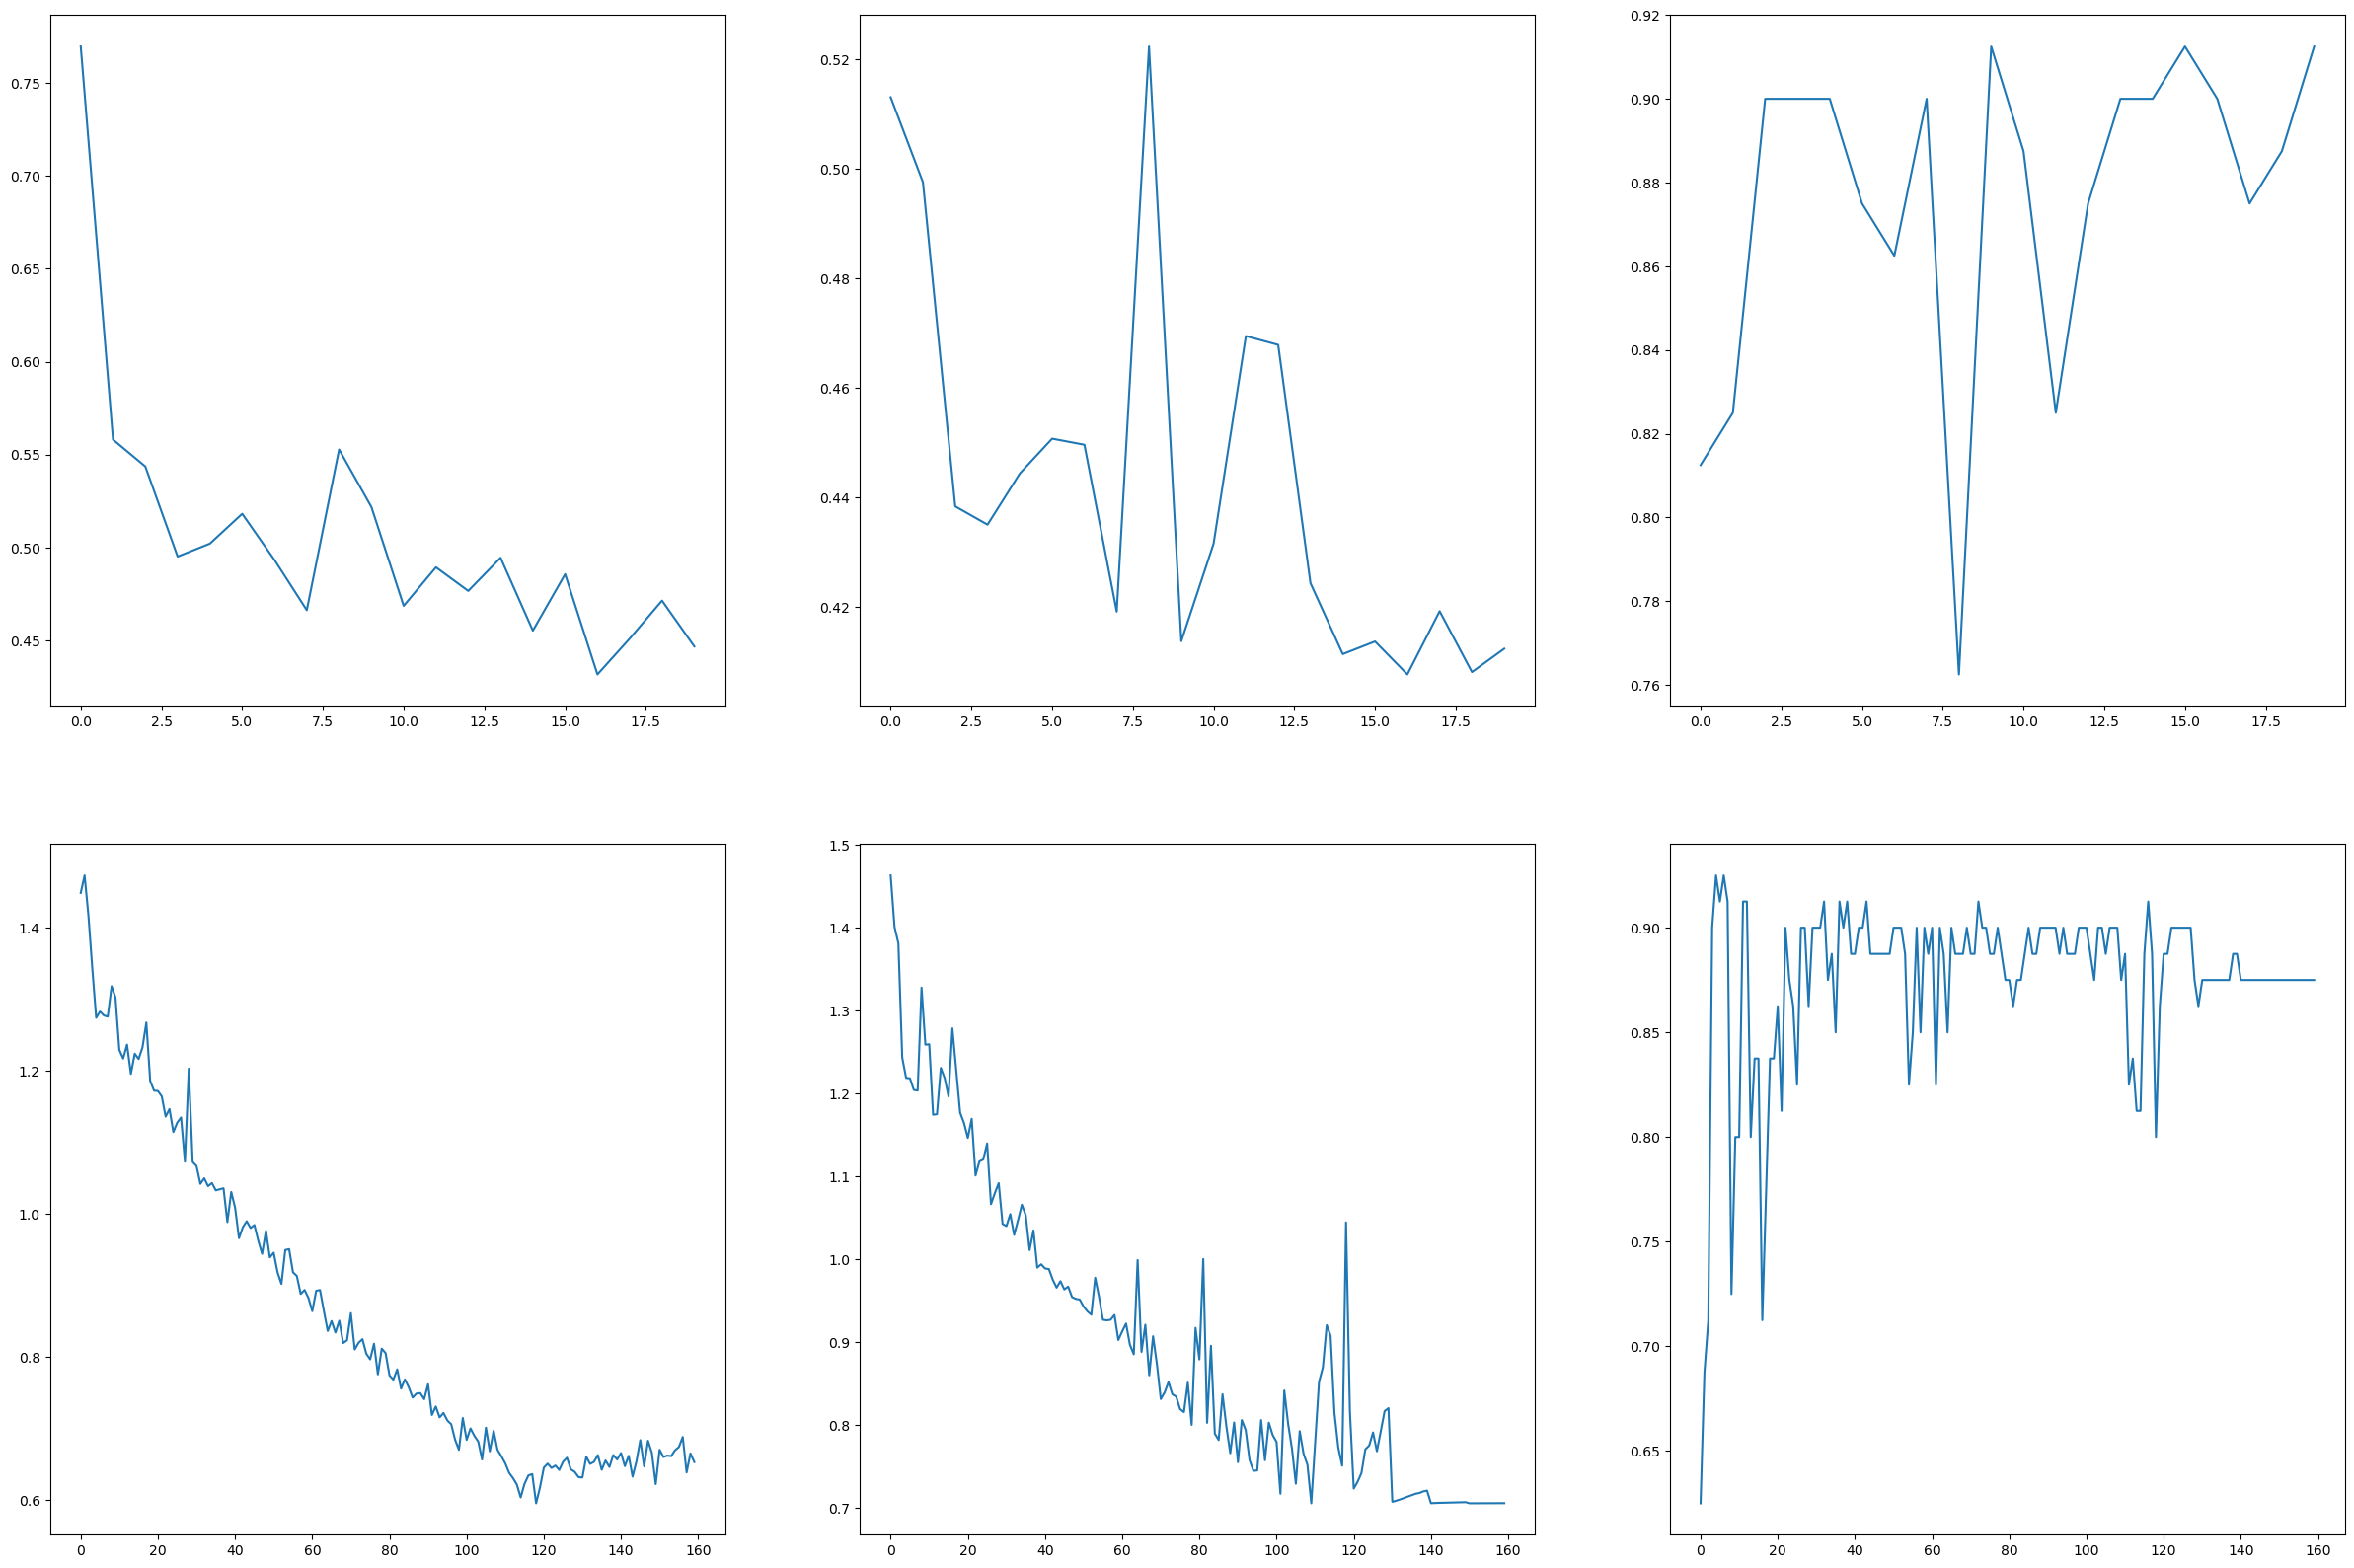

In [21]:
plt.figure(figsize=(30,20))
plt.subplot(231)
plt.plot(effnet_dense_history['train_loss'])
plt.subplot(232)
plt.plot(effnet_dense_history['val_loss'])
plt.subplot(233)
plt.plot(effnet_dense_history['val_acc'])
plt.subplot(234)
plt.plot(effnet_fine_tune_history['train_loss'])
plt.subplot(235)
plt.plot(effnet_fine_tune_history['val_loss'])
plt.subplot(236)
plt.plot(effnet_fine_tune_history['val_acc'])

## Test

In [22]:
model.load_weights(weights+'Fine_Tune/best_model')
model.evaluate(test)
tf.keras.backend.clear_session()

5/5 [==============================] - 1s 195ms/step - loss: 0.6597 - categorical_accuracy: 0.8750 - precision_2: 0.9556 - precision_3: 0.7407


# ConvNext

In [23]:
weights = '/home/jj/FYP/Checkpoint/Convnext_INbreast_CLAHE/'
train_log = '/home/jj/FYP/log/Convnext_INbreast_CLAHE/'

In [24]:
weights = '/home/jj/FYP/Checkpoint/Convnext_INbreast_CLAHE/'
train_log = '/home/jj/FYP/log/Convnext_INbreast_CLAHE/'
model, convnext_dense_history = Model_Training.main(    
    'convnext',
    train,
    val,
    epochs=20,
    patience=4,
    Earlystop=False,
    augmentation = True,
    trainable_layers = False,
    regulariser=False,
    train_log= train_log+'dense.csv',
    load_weights = False,
    save_weights = weights+'Dense/best_model',
    learning_rate=1e-4,
    optimiser=tf.keras.optimizers.Adam(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
    callbacks = [PrintLR()],
    img_height=300,img_width=300)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 convnext_base (Functional)  (None, 9, 9, 1024)        87566464  
                                                                 
 flatten (Flatten)           (None, 82944)             0         
                                                                 
 dense (Dense)               (None, 8)                 663560    
                                                                 
 dense_1 (Dense)             (None, 8)                 72        
                                                                 
 dropout (Dropout)           (None, 8)                 0     

## Fine Tune

In [25]:
model, convnext_fine_tune_history = Model_Training.main(    
    'convnext',
    train,
    val,
    epochs=300,
    patience=10,
    Earlystop=50,
    augmentation = True,
    # Top 25 layers are the stage 3 blocks
    trainable_layers = 25,
    regulariser=tf.keras.regularizers.l2(0.1),
    train_log= train_log+'Fine_Tune.csv',
    load_weights = weights+'Dense/best_model',
    save_weights = weights+'Fine_Tune/best_model',
    learning_rate=1e-3,
    optimiser=tf.keras.optimizers.legacy.SGD(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
    callbacks = [PrintLR()],
    img_height=300,img_width=300)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 300, 300, 3)       0         
                                                                 
 convnext_base (Functional)  (None, 9, 9, 1024)        87566464  
                                                                 
 flatten_1 (Flatten)         (None, 82944)             0         
                                                                 
 dense_4 (Dense)             (None, 8)                 663560    
                                                                 
 dense_5 (Dense)             (None, 8)                 72        
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0   

## Figures

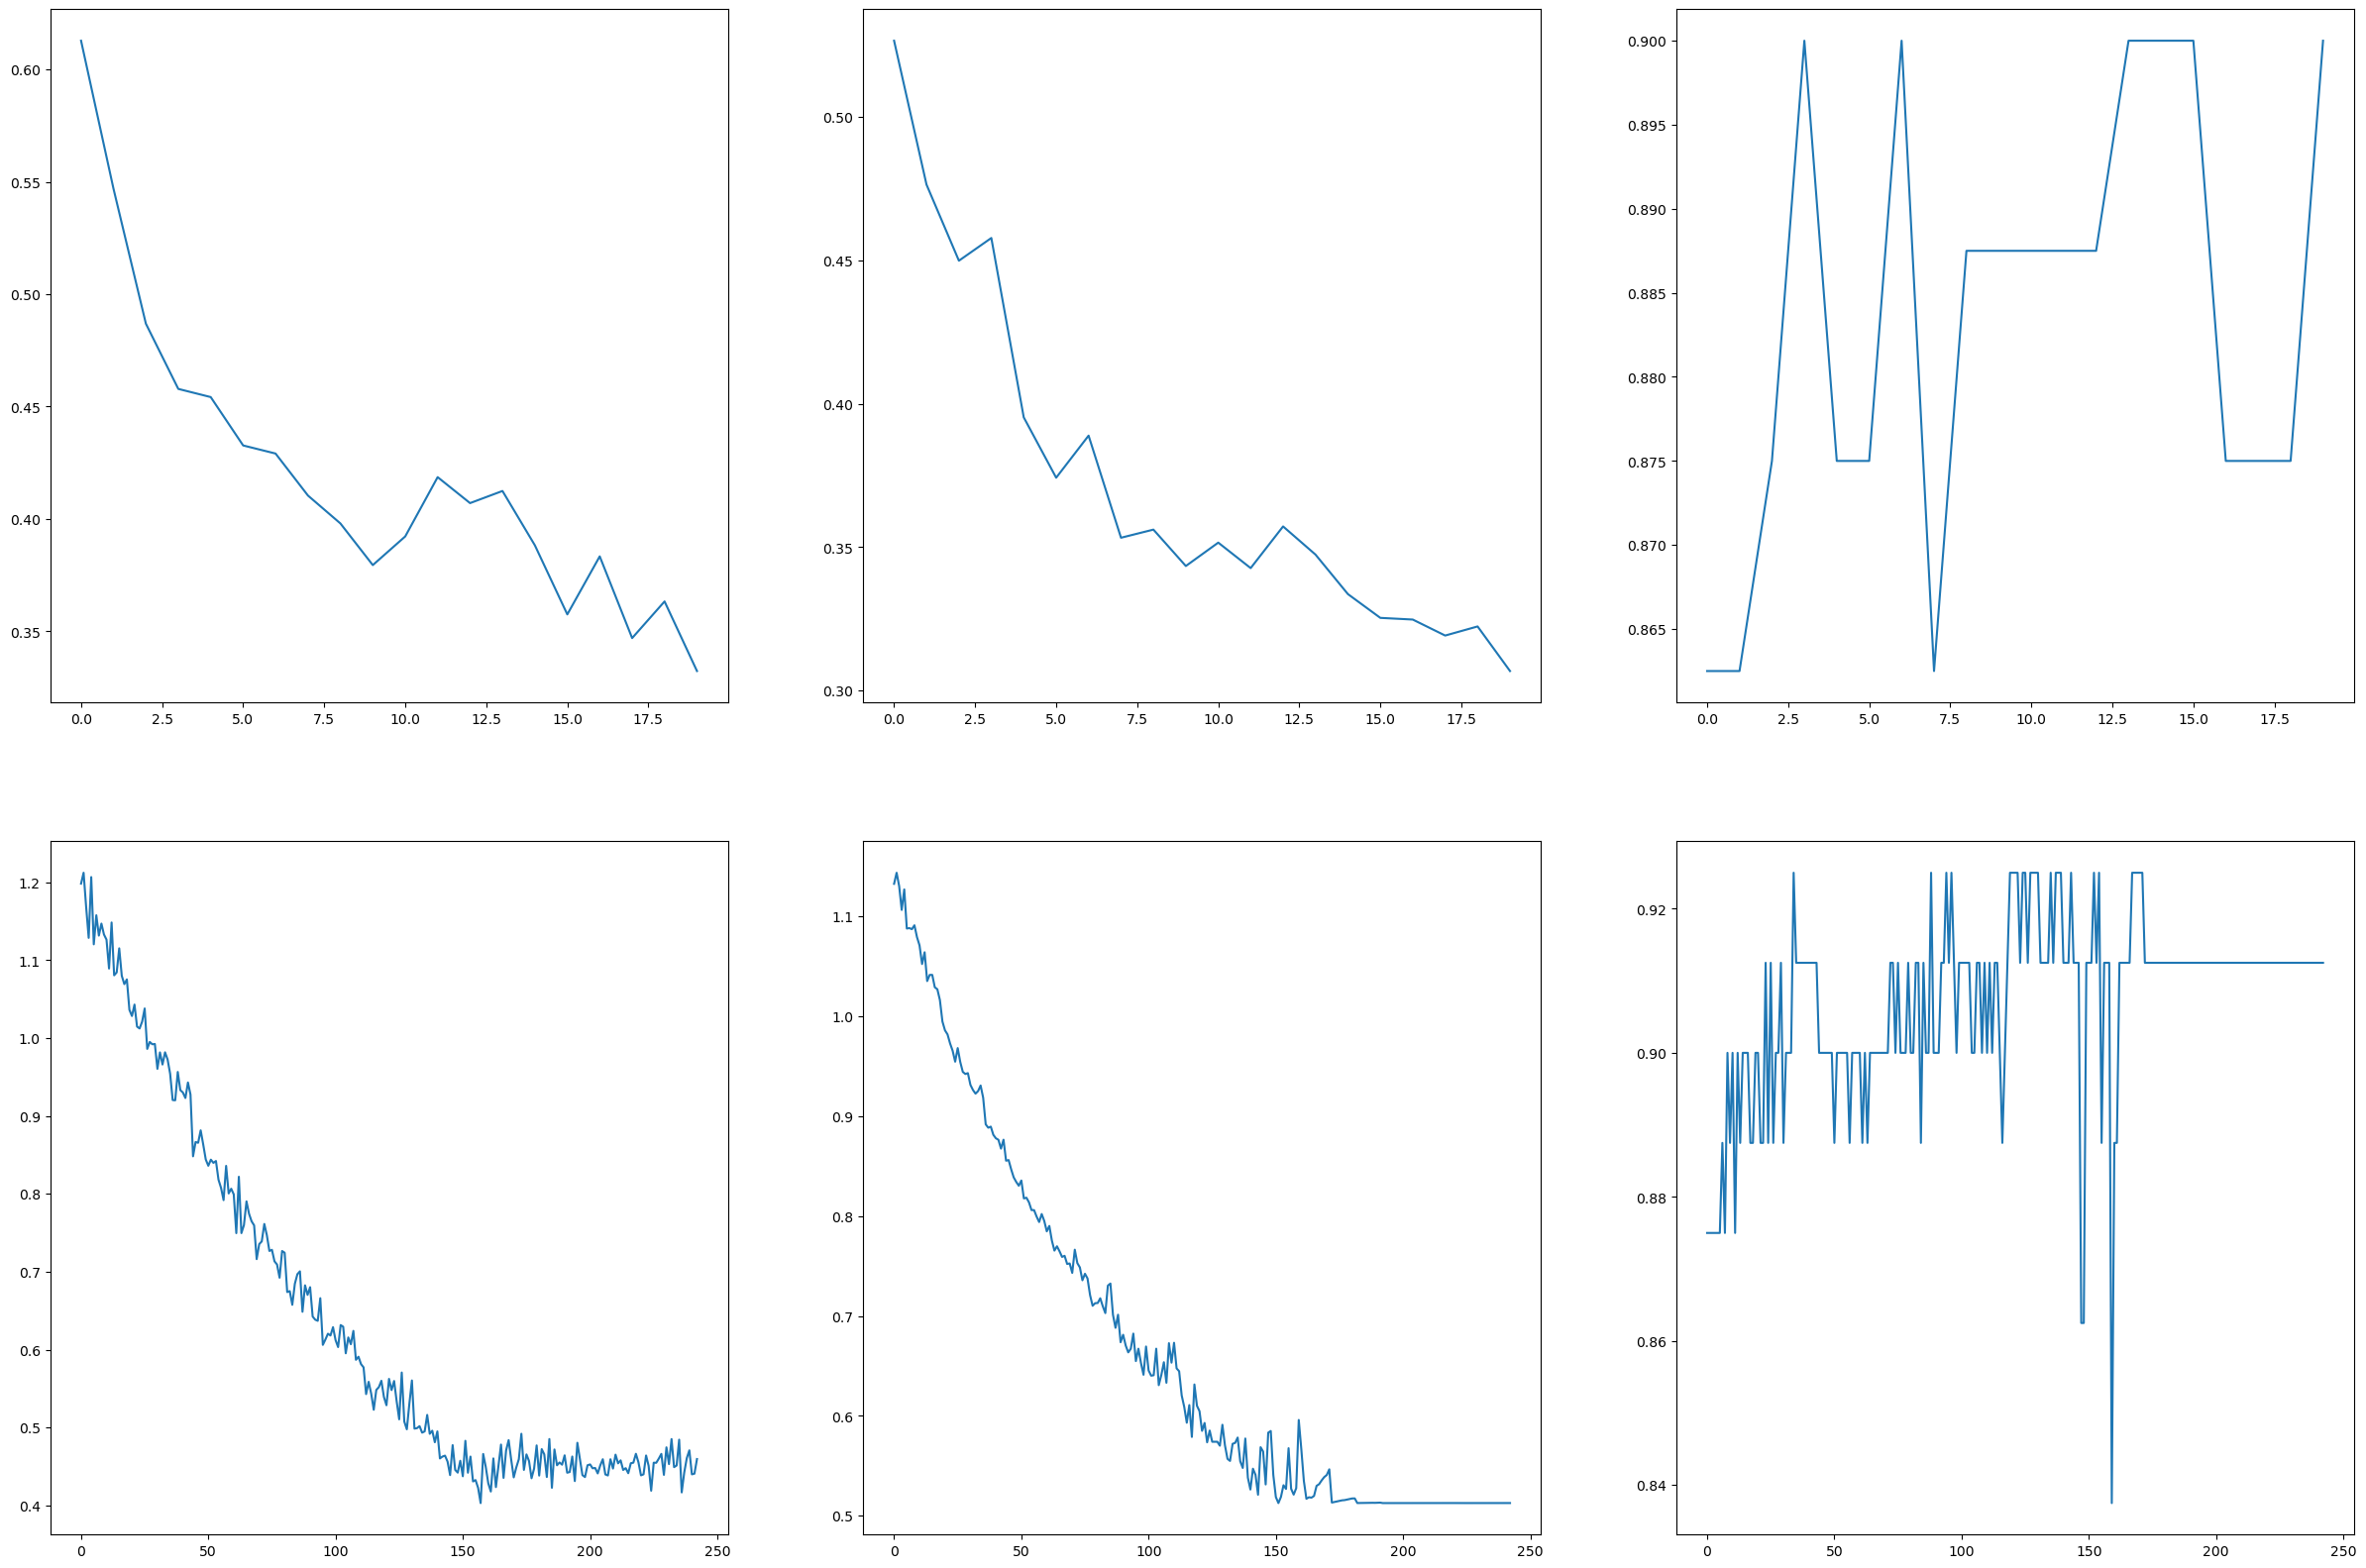

In [26]:
plt.figure(figsize=(30,20))
plt.subplot(231)
plt.plot(convnext_dense_history['train_loss'])
plt.subplot(232)
plt.plot(convnext_dense_history['val_loss'])
plt.subplot(233)
plt.plot(convnext_dense_history['val_acc'])
plt.subplot(234)
plt.plot(convnext_fine_tune_history['train_loss'])
plt.subplot(235)
plt.plot(convnext_fine_tune_history['val_loss'])
plt.subplot(236)
plt.plot(convnext_fine_tune_history['val_acc'])

## Test

In [27]:
model.load_weights(weights+'Fine_Tune/best_model')
model.evaluate(test)
tf.keras.backend.clear_session()

5/5 [==============================] - 3s 669ms/step - loss: 0.5881 - categorical_accuracy: 0.8472 - precision_2: 0.8421 - precision_3: 0.8667
